In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.dataset.dataset_classes import GeneDataset
from source.python.cnn.models              import Zrimec2020r
from source.python.cnn.models              import Zrimec2020c
from source.python.cnn.models              import Washburn2019r
from source.python.cnn.models              import Washburn2019c

from source.python.dataset.dataset_utils   import to_dataloaders
from source.python.dataset.dataset_utils   import to_dataloader
from source.python.dataset.dataset_utils   import to_gene_dataset
from source.python.dataset.dataset_utils   import show_dataloader
from source.python.dataset                 import dataset_split
from source.python.dataset                 import dataset_utils
from source.python.cnn                     import cnn_model
from source.python.cnn                     import cnn_mutation
from source.python.cnn                     import cnn_plot
from source.python.cnn                     import cnn_utils
from source.python.io                      import loader
from source.python.io                      import writer
from source.python                         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 10.555 GB



# 1. Setup

In [5]:
# Define output and inputs

VERBOSE        = False
FEATURES       = True
GENERATOR      = 'group'

MODEL_MODE     = 'regression'
MODEL_ARCH     = 'zrimec'
MODEL_PARAMS   = 0
MODEL_EPOCHS   = 50

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	parser.add_argument('--model_epochs',   type = int,         default = 50)
	parser.add_argument('--model_params',   type = int_or_none, default = None)
	parser.add_argument('--model_arch',     type = str,         default = 'zrimec',     choices = ['zrimec', 'washburn'])
	parser.add_argument('--model_mode',     type = str,         default = 'regression', choices = ['regression', 'classification'])
	parser.add_argument('--generator',      type = str,         default = 'group',      choices = ['stratified', 'group', 'random'])
	parser.add_argument('--features',       type = str_of_bool, default = False)

	args = vars(parser.parse_args())

	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']
	MODEL_MODE     = args['model_mode']
	MODEL_ARCH     = args['model_arch']
	GENERATOR      = args['generator']
	FEATURES       = args['features']

Running as .ipynb



In [7]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp09-scerevisiae')
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'  Root Directory : {CWD}')
print(f'Output Directory : {OUT_DATA}')
print(f'Output Directory : {OUT_MODEL}')
print(f'Output Directory : {OUT_PLOT}')
print()

  Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp09-scerevisiae
Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp09-scerevisiae\model
Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp09-scerevisiae\plot



In [8]:
# Load model config

if MODEL_ARCH == 'washburn' : filename = os.path.join(RES, 'tuner', 'washburn.json')
if MODEL_ARCH == 'zrimec'   : filename = os.path.join(RES, 'tuner', 'zrimec.json')

model_config = loader.load_json(filename = filename)

# 2. Config

In [9]:
# Create final report

final_report = dict()

In [10]:
# Single global config

CONFIG = {
	'core/device'             : DEVICE,
	'core/random'             : None,
	'core/rootdir'            : ROOT,
	'core/verbose'            : VERBOSE,
	'core/plots'              : 5,
	'dataset/expanddim'       : None,
	'dataset/sequence/start'  : None,
	'dataset/sequence/end'    : None,
	'dataset/split/generator' : GENERATOR,
	'dataset/split/test'      : 0.2,
	'dataset/split/valid'     : 0.2,
	'model/arch'              : MODEL_ARCH,
	'model/mode'              : MODEL_MODE,
	'model/epochs'            : MODEL_EPOCHS,
	'model/features'          : FEATURES,
	'model/input/channels'    : 1,
	'model/input/features'    : None,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/output/heads'      : None,
	'model/output/size'       : None,
	'model/params/id'         : MODEL_PARAMS
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [11]:
# Configure criterion

if CONFIG['model/mode'] == 'regression'     : CONFIG['criterion/name'] = 'corrected-mse'
if CONFIG['model/mode'] == 'classification' : CONFIG['criterion/name'] = 'entropy'

In [12]:
# Update specific params

if CONFIG['model/params/id'] is not None and CONFIG['model/params/id'] >= 0 :
	CONFIG.update(model_config[CONFIG['model/params/id']])

	CONFIG['dataset/batch/train'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/valid'] = CONFIG['dataset/batch_size']
	CONFIG['dataset/batch/test']  = CONFIG['dataset/batch_size']

In [13]:
# Update config

if CONFIG['model/arch'] == 'zrimec' :   CONFIG['dataset/expanddim'] = None
if CONFIG['model/arch'] == 'washburn' : CONFIG['dataset/expanddim'] = 0

In [14]:
# Prints

print('Use Features  : {}'.format(CONFIG['model/features']))
print('Random Seed   : {}'.format(CONFIG['core/random']))
print()

Use Features  : True
Random Seed   : 511182041



# 3. Dataloader

In [15]:
# Load and check data

file = os.path.join(RES, 'genome')
file = os.path.join(file, 'scerevisiae', 'scerevisiae.rsd1.lmbda_22.npz')
file = numpy.load(file)

train_onehot  = file['arr_0']
train_feature = file['arr_2']
train_target  = file['arr_4']

test_onehot   = file['arr_1']
test_feature  = file['arr_3']
test_target   = file['arr_5']

to_double = lambda x : x.astype(numpy.float64)
to_float  = lambda x : x.astype(numpy.float32)
to_common = to_double

train = list()
train.append(to_common(train_onehot))
train.append(to_common(train_feature))
train.append(to_common(train_target).reshape((-1, 1)))

test = list()
test.append(to_common(test_onehot))
test.append(to_common(test_feature))
test.append(to_common(test_target).reshape((-1, 1)))

train_onehot  = train[0]
train_feature = train[1]
train_tpm     = train[2]

test_onehot   = test[0]
test_feature  = test[1]
test_tpm      = test[2]

train_onehot = numpy.swapaxes(train_onehot, 1, 2)
test_onehot  = numpy.swapaxes(test_onehot,  1, 2)

train_indices = [i for i in range(numpy.shape(train_tpm)[0])]
test_indices  = [i for i in range(numpy.shape( test_tpm)[0])]

In [16]:
# Print and ensure configuration

if CONFIG['core/verbose'] :
	cf = lambda x : ', '.join([str(i) for i in x])

	print('Train onehot  : {}'.format(cf(numpy.shape(train_onehot))))
	print('Train feature : {}'.format(cf(numpy.shape(train_feature))))
	print('Train tpm     : {}'.format(cf(numpy.shape(train_tpm))))
	print('Train indices : {}'.format(len(train_indices)))
	print()

	print('Test onehot  : {}'.format(cf(numpy.shape(test_onehot))))
	print('Test feature : {}'.format(cf(numpy.shape(test_feature))))
	print('Test tpm     : {}'.format(cf(numpy.shape(test_tpm))))
	print('Test indices : {}'.format(len(test_indices)))
	print()

CONFIG['model/input/features'] = numpy.shape(train_feature)[1]
CONFIG['model/input/height']   = numpy.shape(train_onehot)[1]
CONFIG['model/input/width']    = numpy.shape(train_onehot)[2]
CONFIG['model/output/size']    = numpy.shape(train_tpm)[1]

if CONFIG['model/arch'] == 'zrimec'   : CONFIG['model/fc3/features'] = CONFIG['model/output/size']
if CONFIG['model/arch'] == 'washburn' : CONFIG['model/fc3/features'] = CONFIG['model/output/size']

if CONFIG['core/verbose'] :
	print('Input Features : {}'.format(CONFIG['model/input/features']))
	print('Input Height   : {}'.format(CONFIG['model/input/height']))
	print('Input Width    : {}'.format(CONFIG['model/input/width']))
	print('Input Channels : {}'.format(CONFIG['model/input/channels']))
	print('Output Size    : {}'.format(CONFIG['model/output/size']))
	print()

In [17]:
# Convert into my format

cf = lambda x : 'G{:04d}'.format(x)

train_names     = [cf(i)                    for i in train_indices]
train_sequences = {cf(i) : train_onehot[i]  for i in train_indices}
train_features  = {cf(i) : train_feature[i] for i in train_indices}
train_targets   = {cf(i) : train_tpm[i]     for i in train_indices}

test_names      = [cf(i)                    for i in test_indices]
test_sequences  = {cf(i) : test_onehot[i]   for i in test_indices}
test_features   = {cf(i) : test_feature[i]  for i in test_indices}
test_targets    = {cf(i) : test_tpm[i]      for i in test_indices}

In [18]:
# Create train and valid dataloader

train_dataset = GeneDataset(
	names       = train_names,
	sequences   = train_sequences,
	features    = train_features,
	targets     = train_targets,
	onehot      = False,
	expand_dims = CONFIG['dataset/expanddim'],
	groups      = train_indices,
	start       = CONFIG['dataset/sequence/start'],
	end         = CONFIG['dataset/sequence/end']
)

dataloaders = to_dataloaders(
	dataset     = train_dataset,
	generator   = CONFIG['dataset/split/generator'],
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/test'],
		'test'  : CONFIG['dataset/split/valid']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/test'],
		'test'  : CONFIG['dataset/batch/valid']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[2]

In [19]:
# Display train dataloader

show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [20]:
# Display valid dataloader

show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [21]:
# Create test dataloader

test_dataset = GeneDataset(
	names       = test_names,
	sequences   = test_sequences,
	features    = test_features,
	targets     = test_targets,
	onehot      = False,
	expand_dims = CONFIG['dataset/expanddim'],
	groups      = test_indices,
	start       = CONFIG['dataset/sequence/start'],
	end         = CONFIG['dataset/sequence/end']
)

test_dataloader = to_dataloader(
	dataset    = test_dataset,
	indices    = test_indices,
	batch_size = CONFIG['dataset/batch/test']
)

In [22]:
# Display test dataloader

show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Structure

In [23]:
# Create and display the model structure

if CONFIG['model/arch'] == 'zrimec' :
	if CONFIG['model/mode'] == 'regression'     : model = Zrimec2020r(params = CONFIG)
	if CONFIG['model/mode'] == 'classification' : model = Zrimec2020c(params = CONFIG, binary = False)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features']
	))

if CONFIG['model/arch'] == 'washburn' :
	if CONFIG['model/mode'] == 'regression'     : model = Washburn2019r(params = CONFIG)
	if CONFIG['model/mode'] == 'classification' : model = Washburn2019c(params = CONFIG, binary = False)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_channels = CONFIG['model/input/channels'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

print()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [32, 4, 2150]             [32, 1]                   --
├─Zrimec2020: 1-1                        [32, 4, 2150]             [32, 128]                 --
│    └─Conv1d: 2-1                       [32, 4, 2150]             [32, 256, 2150]           5,376
│    └─LeakyReLU: 2-2                    [32, 256, 2150]           [32, 256, 2150]           --
│    └─BatchNorm1d: 2-3                  [32, 256, 2150]           [32, 256, 2150]           512
│    └─Dropout: 2-4                      [32, 256, 2150]           [32, 256, 2150]           --
│    └─MaxPool1d: 2-5                    [32, 256, 2150]           [32, 256, 717]            --
│    └─Conv1d: 2-6                       [32, 256, 717]            [32, 128, 717]            98,432
│    └─LeakyReLU: 2-7                    [32, 128, 717]            [32, 128, 717]            --
│    └─BatchNorm1d: 2-8    

In [24]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [25]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'smae'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'smae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape',  output_size = CONFIG['model/output/size']),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape', output_size = CONFIG['model/output/size']),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2',    output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'auroc'     : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',     task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'confusion' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'confusion', task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'f1'        : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',        task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'jaccardi'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'jaccardi',  task = 'multiclass', n_classes = CONFIG['model/output/size']),
		'matthews'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews',  task = 'multiclass', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [26]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

## 4.4 Train

In [27]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

## 4.5 Visualization

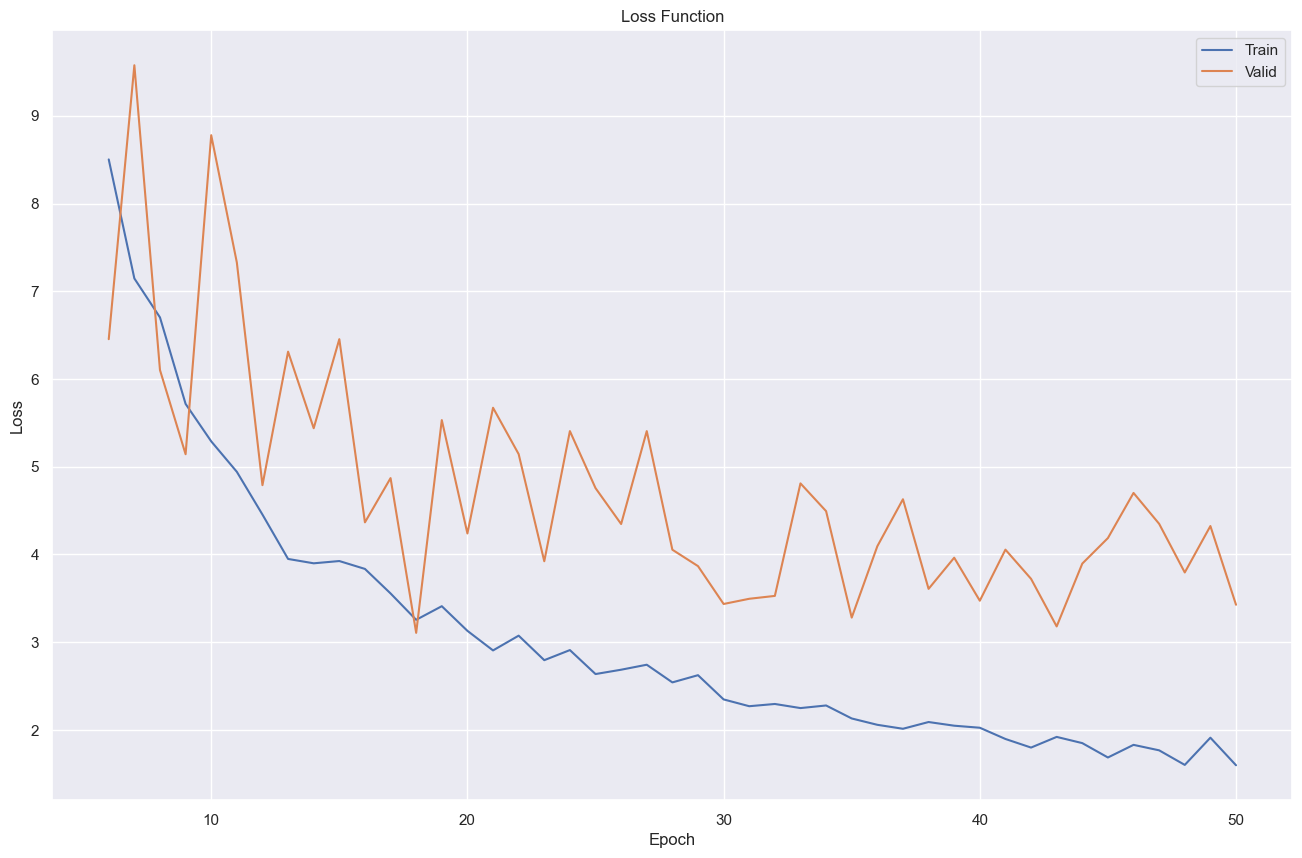

In [28]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report      = report,
	title       = 'Loss Function',
	filename    = os.path.join(OUT_PLOT, model.__name__),
	limit_top   = None,
	limit_bot   = None,
	start_index = CONFIG['core/plots']
)

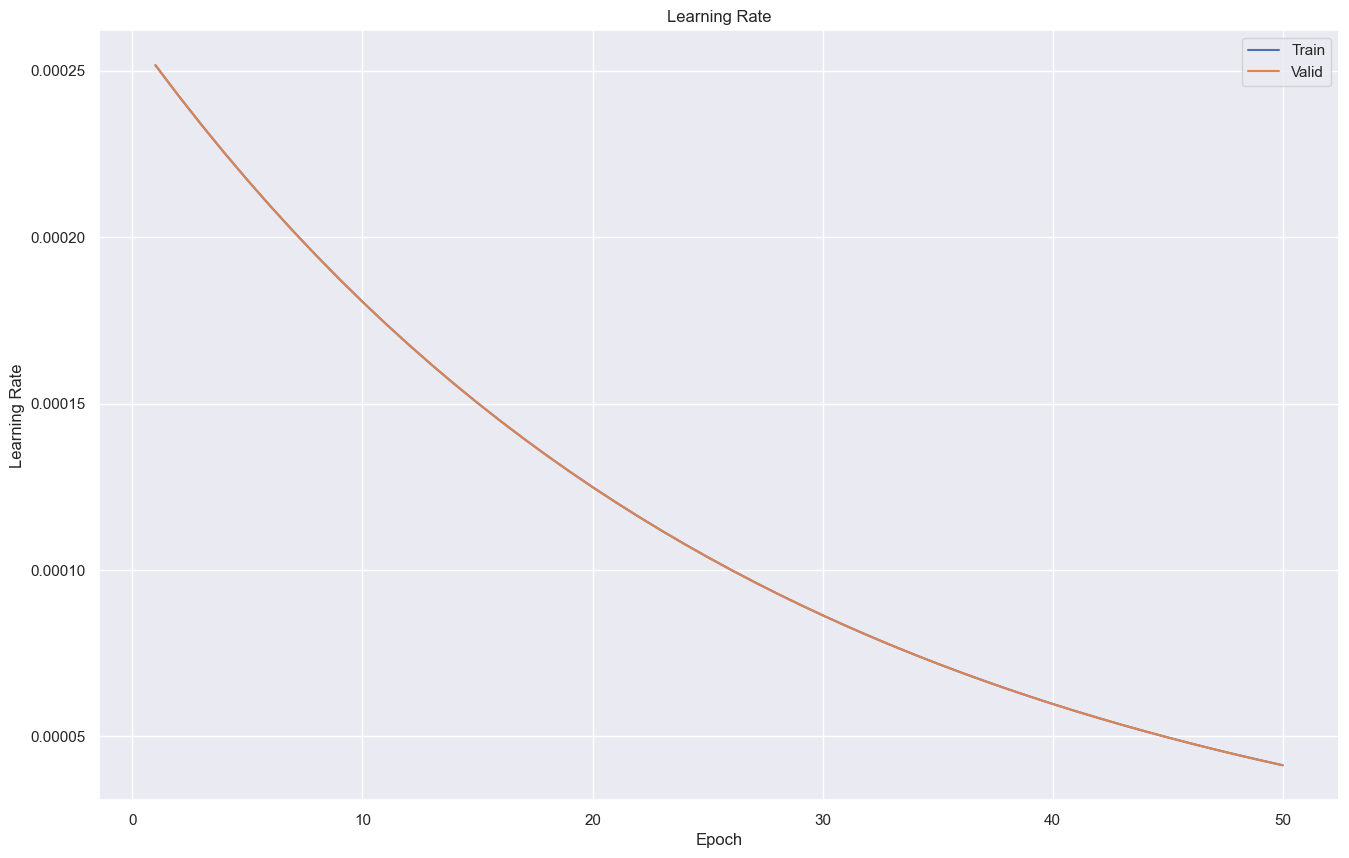

In [29]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report      = report,
	title       = 'Learning Rate',
	filename    = os.path.join(OUT_PLOT, model.__name__),
	limit_top   = None,
	limit_bot   = None,
	start_index = None
)

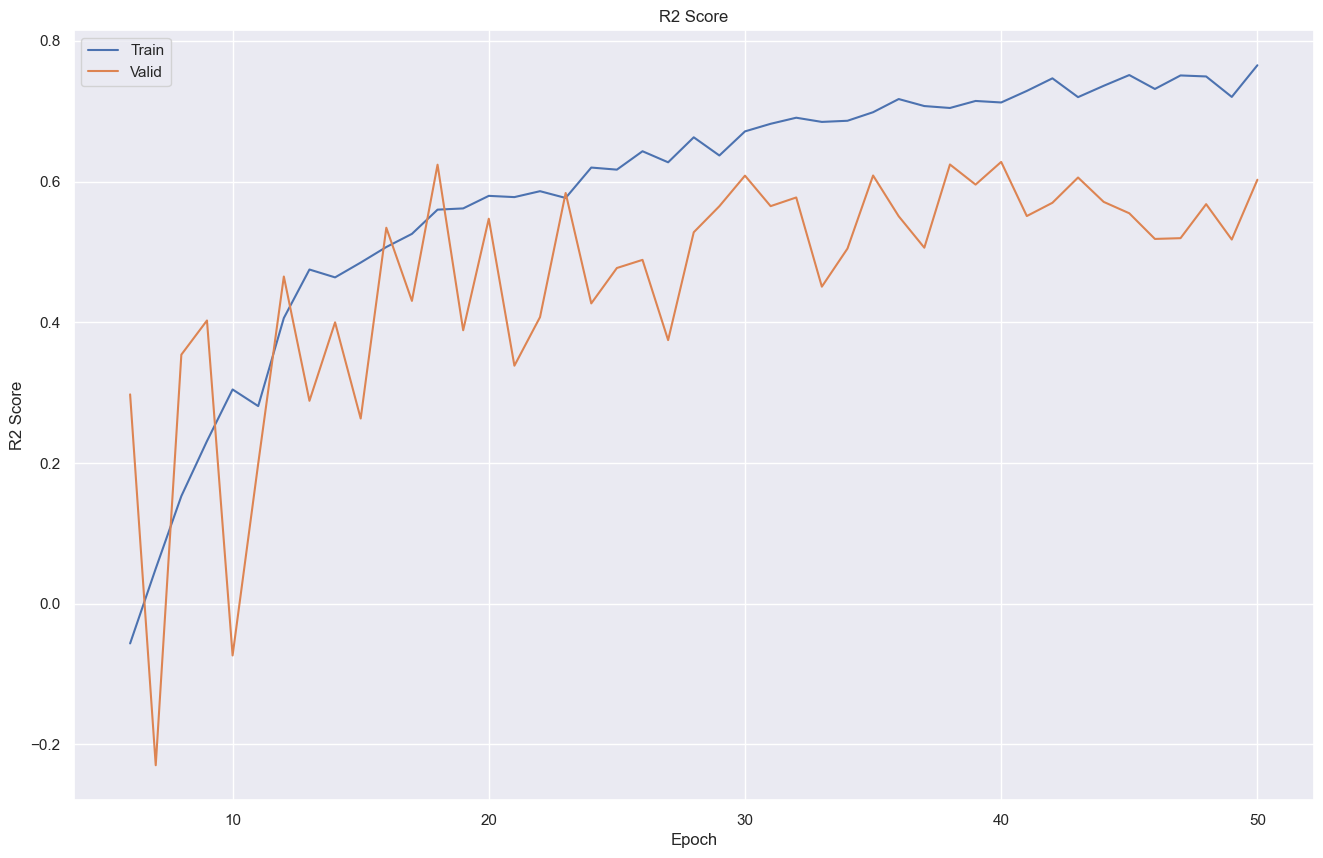

In [30]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report      = report,
		title       = 'R2 Score',
		filename    = os.path.join(OUT_PLOT, model.__name__),
		limit_top   = None,
		limit_bot   = None,
		start_index = CONFIG['core/plots']
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report      = report,
		title       = 'Accuracy',
		filename    = os.path.join(OUT_PLOT, model.__name__),
		limit_top   = None,
		limit_bot   = None,
		start_index = CONFIG['core/plots']
	)

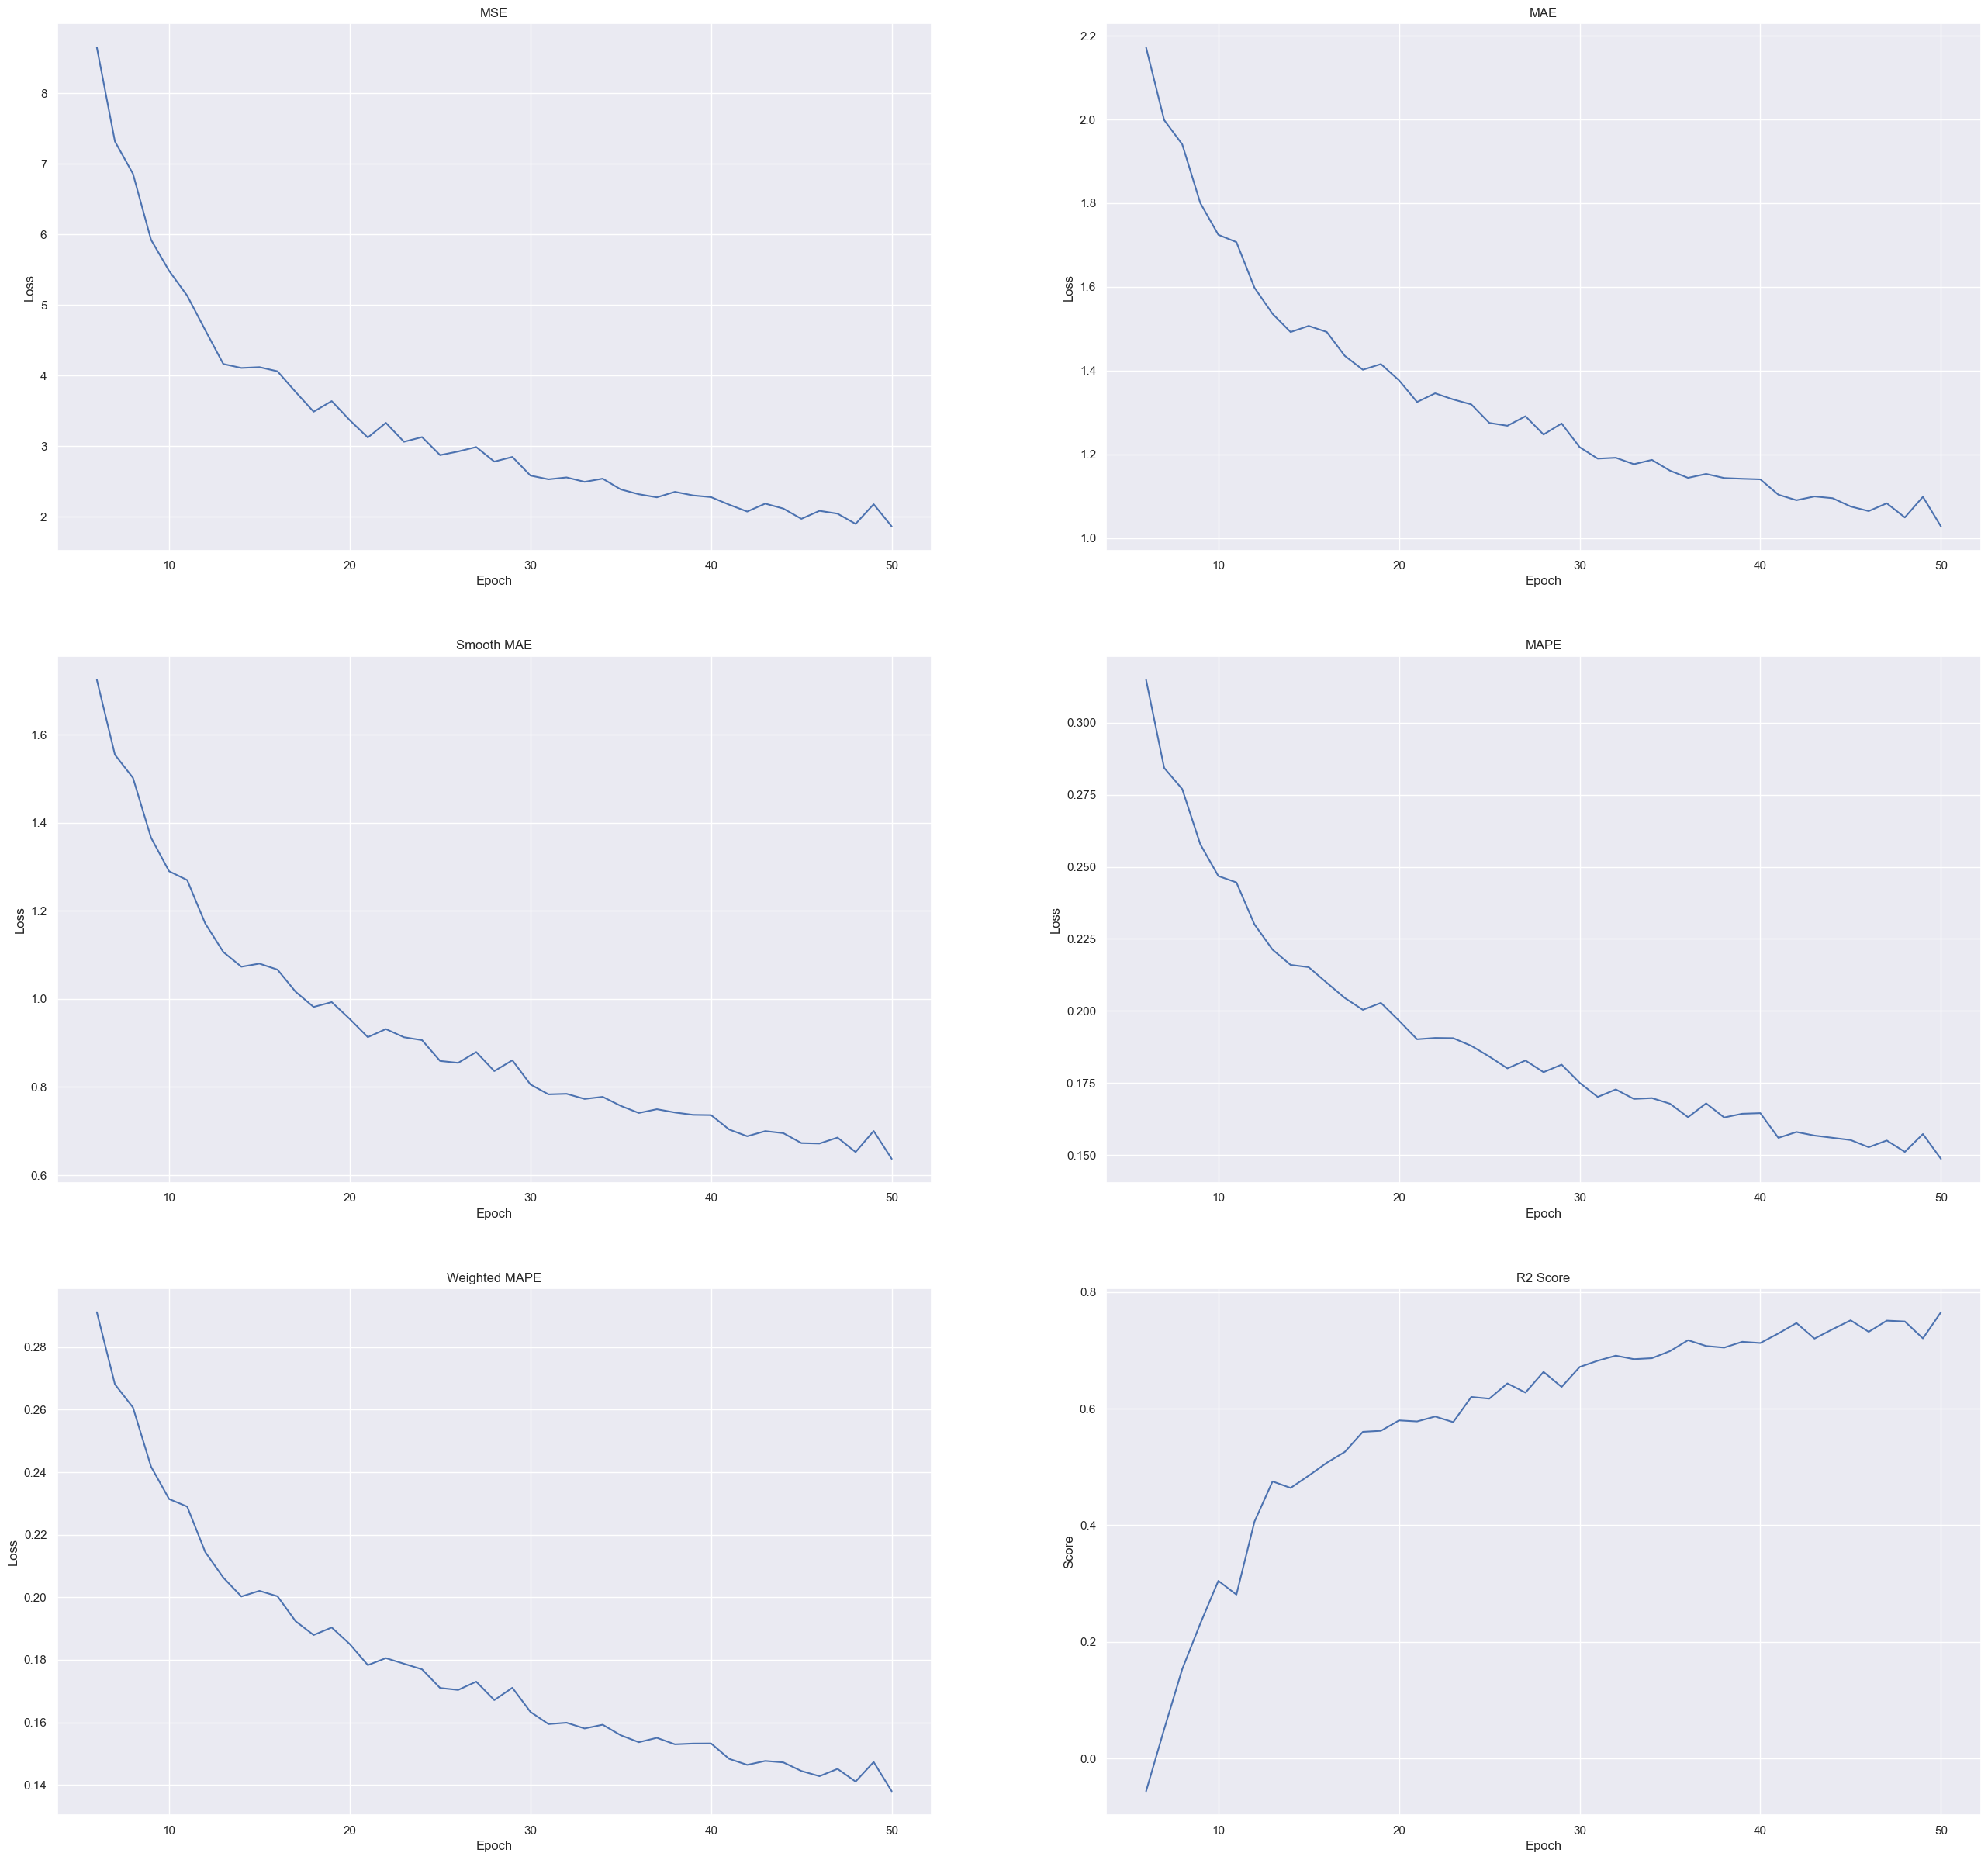

In [31]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'train',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-train'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

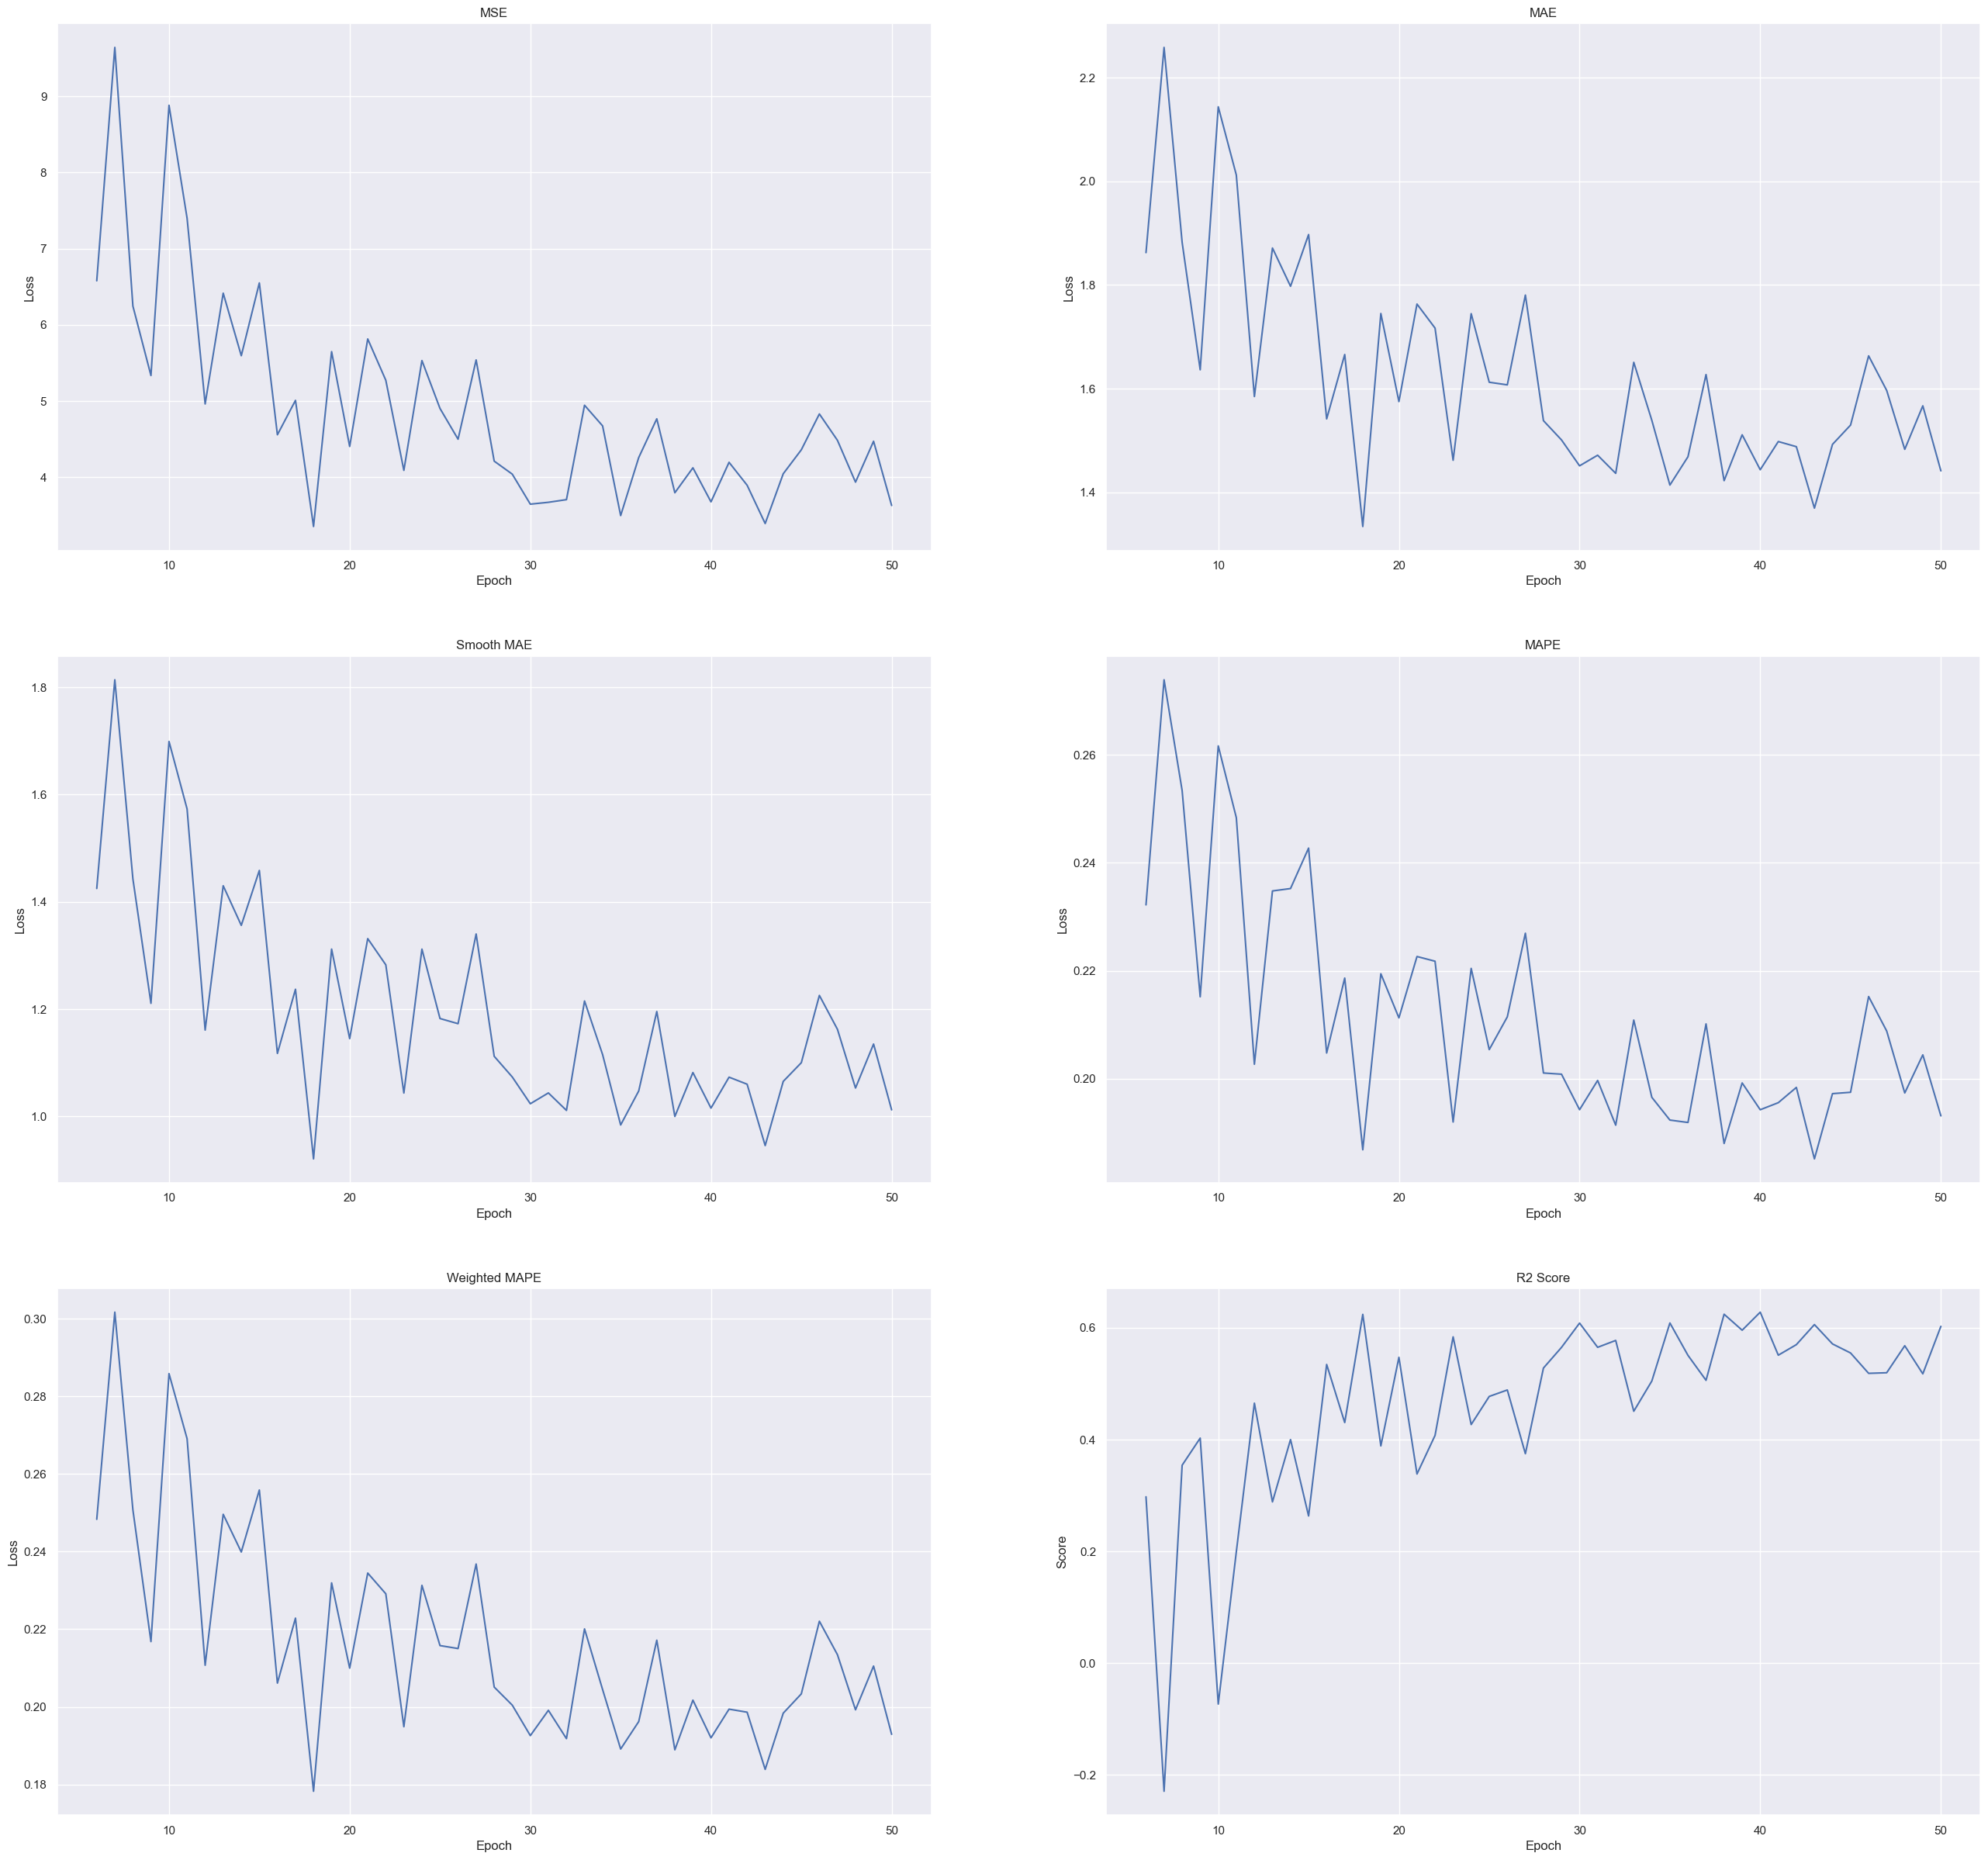

In [32]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report       = report,
	mode         = 'valid',
	filename     = os.path.join(OUT_PLOT, model.__name__ + '-valid'),
	apply_limits = False,
	start_index  = CONFIG['core/plots']
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [33]:
# Load last model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

final_report['evaluation/last/epoch'] = checkpoint['epoch']
final_report['evaluation/last/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 50
 Loss : 3.42690



<All keys matched successfully>

In [34]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/last/test'
	)

Mode   : evaluation/last/test
R2     :    0.51332
MAE    :    1.42769
MSE    :    3.38716
MAPE   :    0.17957
WMAPE  :    0.18768



## 5.2 Best Model

### 5.2.1 Evaluation

In [35]:
# Load best model

checkpoint = loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

final_report['evaluation/best/epoch'] = checkpoint['epoch']
final_report['evaluation/best/loss']  = checkpoint['loss']

print('Epoch : ' + '{}'.format(final_report['evaluation/last/epoch']))
print(' Loss : ' + '{:.5f}'.format(final_report['evaluation/last/loss']))
print()

model.load_state_dict(checkpoint['models'])

Epoch : 50
 Loss : 3.42690



<All keys matched successfully>

In [36]:
# Evaluate the full model on keep test

if CONFIG['model/mode'] == 'regression' :
	report_keep, final_report = cnn_model.eval_regressor_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

if CONFIG['model/mode'] == 'classification' :
	report_keep, final_report = cnn_model.eval_classifier_with_report(
		model  = model,
		params = model_params,
		report = final_report,
		mode   = 'evaluation/best/test'
	)

Mode   : evaluation/best/test
R2     :    0.60043
MAE    :    1.25011
MSE    :    2.82812
MAPE   :    0.16625
WMAPE  :    0.16645



### 5.2.2 Custom

In [37]:
# Display the first few evaluation item predictions and expectations

if CONFIG['model/mode'] == 'regression' :
	cnn_utils.display_regression_predictions(
		report = report_keep,
		n      = 2
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_utils.display_classification_predictions(
		report = report_keep,
		n      = 2
	)

 Key : G0368
True : [ 8.13179]
Pred : [ 8.59695]
 MAE : [ 0.46516]
 MSE : [ 0.21637]
  R2 : [ 0.82054]

 Key : G0230
True : [ 8.27500]
Pred : [ 5.68653]
 MAE : [ 2.58847]
 MSE : [ 6.70017]
  R2 : [ 0.44072]



### 5.2.3 Visualization

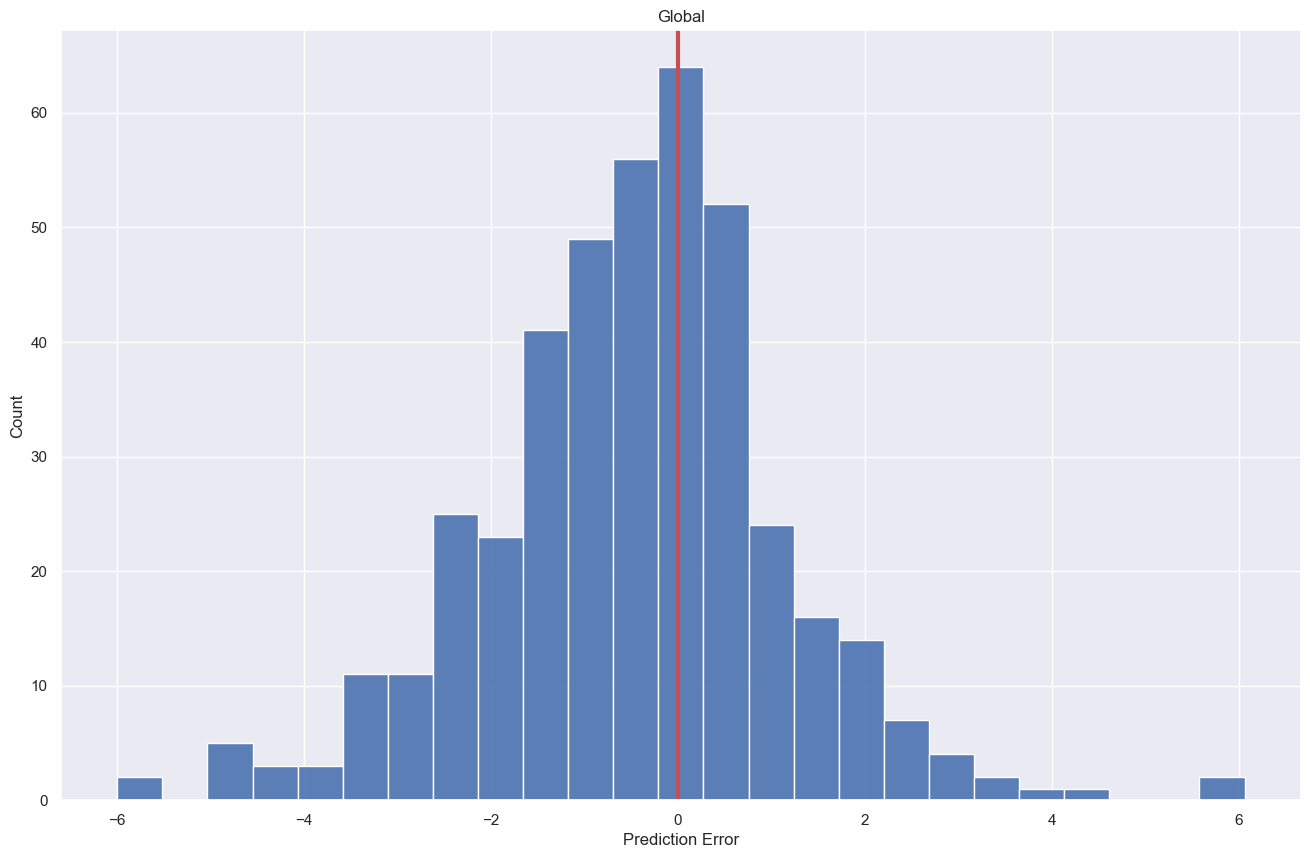

In [38]:
# Display prediction error per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_prediction_error_grid(
		report   = report_keep,
		order    = ['global'],
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

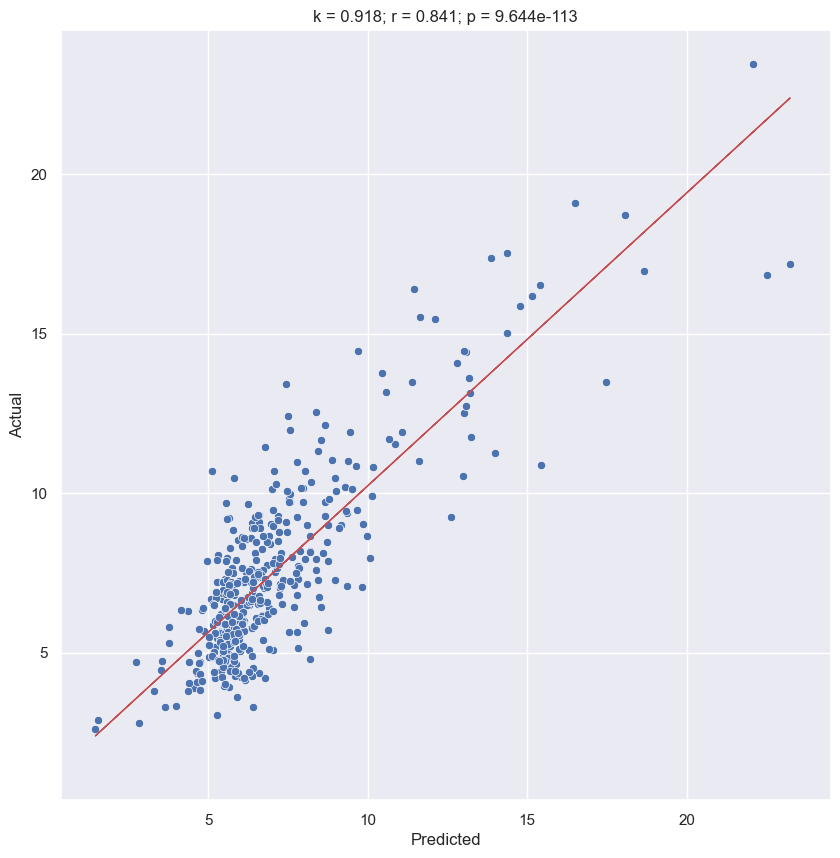

In [39]:
# Display prediction linear regression per group

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_linear_regression_grid(
		report   = report_keep,
		order    = ['global'],
		filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
	)

# 6. Save

In [40]:
# Convert reports from numpy array to lists

def ensure_json_validity (item) :
	if   isinstance(item, dict)          : pass
	elif isinstance(item, list)          : return item
	elif isinstance(item, numpy.ndarray) : return item.tolist()
	elif isinstance(item, float)         : return item
	elif isinstance(item, int)           : return item
	elif isinstance(item, str)           : return item
	else                                 : return None

	data = dict()

	for key in item.keys() :
		data[key] = ensure_json_validity(item[key])

	return data

report_keep = ensure_json_validity(report_keep)

In [41]:
# Save results

for key, value in final_report.items() :
	if isinstance(value, numpy.float32) :
		final_report[key] = float(value)

writer.write_json(
	data     = final_report,
	filename = os.path.join(OUT_DATA, 'report.json')
)

writer.write_json(
	data     = report_keep,
	filename = os.path.join(OUT_DATA, 'report_keep.json')
)

writer.write_json(
	data     = {k : v for k, v in CONFIG.items() if k != 'core/device'},
	filename = os.path.join(OUT_DATA, 'config.json')
)